Pierre Navaro - [Institut de Recherche Mathématique de Rennes](https://irmar.univ-rennes1.fr) - [CNRS](http://www.cnrs.fr/)

# References
- [Outils pour le Big Data - Pierre Nerzic 🇫🇷](https://perso.univ-rennes1.fr/pierre.nerzic/Hadoop/)
- [Writing an Hadoop MapReduce Program in Python - Michael G. Noll](http://www.michael-noll.com/tutorials/writing-an-hadoop-mapreduce-program-in-python/)
- [Hadoop MapReduce Framework Tutorials with Examples - Matthew Rathbone](https://blog.matthewrathbone.com/2013/01/05/a-quick-guide-to-hadoop-map-reduce-frameworks.html)
- [Python course: Lambda, filter, reduce and map](http://www.python-course.eu/lambda.php)
- [Mastering Python for Data Science - Samir Madhavan](https://www.packtpub.com/big-data-and-business-intelligence/mastering-python-data-science)
* [Implementing MapReduce with multiprocessing](https://pymotw.com/2/multiprocessing/mapreduce.html)
* [MPI4PY examples](https://github.com/jbornschein/mpi4py-examples)
* [sharedmem package](http://rainwoodman.github.io/sharedmem/)

# Data processing through MapReduce

![MapReduce](http://mm-tom.s3.amazonaws.com/blog/MapReduce.png)

# Python Map Reduce

We will compute a norm with this process

In [15]:
V = [4,1,2,3]

- The `map(func, seq)` Python function applies the function func to all the elements of the sequence seq. It returns a new list with the elements changed by func

- The function `reduce(func, seq)` continually applies the function func() to the sequence seq and return a single value. For example, reduce(f, [1, 2, 3, 4, 5]) calculates f(f(f(f(1,2),3),4),5).

In [16]:
from operator import add
from functools import reduce
from math import sqrt

f = lambda x: x*x   # Function applied
L = map(f, V)       # map return a iterator
s = reduce(add,L)   # reduce compute the sum
sqrt(s) == sqrt(sum(map(f,V)))

True

# Wordcount Example

[WordCount](https://hadoop.apache.org/docs/current/hadoop-mapreduce-client/hadoop-mapreduce-client-core/MapReduceTutorial.html#Example:_WordCount_v1.0) is a simple application that counts the number of occurrences of each word in a given input set.

The input  and the output is text files, each line of which contains a 

Each mapper takes a line of text files as input and breaks it into words. It then emits a key/value pair of the word and 1 (separated by a tab). Each reducer sums the counts for each word and emits a single key/value with the word and sum.



In [17]:
%mkdir -p hadoop

In [18]:
from lorem import text
t = text()

with open("hadoop/sample.txt", "w") as sample:
    sample.write(t)

print(t)

Dolor dolor velit dolor quisquam aliquam eius eius. Quaerat magnam ut amet dolor quisquam etincidunt labore. Consectetur adipisci adipisci est magnam amet voluptatem neque. Est aliquam ipsum quaerat magnam neque tempora. Quiquia ipsum numquam numquam labore sit. Non aliquam quiquia porro ut. Aliquam neque neque velit modi dolorem consectetur quiquia.

Sit non adipisci consectetur consectetur. Dolor sed quisquam tempora modi sed neque. Dolore quisquam dolor neque. Velit etincidunt etincidunt sit consectetur dolorem. Quisquam sed sed voluptatem quiquia dolore adipisci voluptatem. Est dolorem consectetur modi.

Dolore non tempora consectetur adipisci numquam. Adipisci quiquia labore est voluptatem dolorem porro tempora. Quisquam consectetur velit modi adipisci dolor. Non quiquia ut aliquam etincidunt. Eius quisquam ut velit aliquam. Amet dolor adipisci labore etincidunt dolore. Sed sed dolor ipsum modi ut.

Aliquam est voluptatem voluptatem aliquam sit aliquam. Dolorem non magnam consecte

### How would you count the number of words in that file?


In [19]:
import re
splitter = re.compile('\w+')
with open('hadoop/sample.txt', 'r') as f:
    data = f.read()
result = len(splitter.findall(data))
result

170

- This  approach load all the data into memory. A very large file might fill up memory. 
- Counting words in each line is totally independent of the others. 
- We can evaluate each piece of data and immediately free up the memory space. 
- Data chunks would be small enough not to stress memory, but big enough for efficient use of the CPU.

In [20]:
result = 0
with open('hadoop/sample.txt', 'r') as f:
    for line in f:
        result += len(splitter.findall(line))
result

170

## Read file and return a key/value pairs

Python function with file name as input and return a sorted sequence of (word, 1) values.

In [21]:
import string

def words(file):
    """
    Read a text file and return a sorted list of (word, 1) values.
    """
    translator = str.maketrans('', '', string.punctuation)
    output = []
    with open(file) as f:
        for line in f:
            line = line.strip()
            line = line.translate(translator)
            for word in line.split():
                word = word.lower()
                output.append((word, 1))
    output.sort()
    return output

In [22]:
words('hadoop/sample.txt')

[('adipisci', 1),
 ('adipisci', 1),
 ('adipisci', 1),
 ('adipisci', 1),
 ('adipisci', 1),
 ('adipisci', 1),
 ('adipisci', 1),
 ('adipisci', 1),
 ('aliquam', 1),
 ('aliquam', 1),
 ('aliquam', 1),
 ('aliquam', 1),
 ('aliquam', 1),
 ('aliquam', 1),
 ('aliquam', 1),
 ('aliquam', 1),
 ('aliquam', 1),
 ('aliquam', 1),
 ('amet', 1),
 ('amet', 1),
 ('amet', 1),
 ('amet', 1),
 ('consectetur', 1),
 ('consectetur', 1),
 ('consectetur', 1),
 ('consectetur', 1),
 ('consectetur', 1),
 ('consectetur', 1),
 ('consectetur', 1),
 ('consectetur', 1),
 ('consectetur', 1),
 ('consectetur', 1),
 ('dolor', 1),
 ('dolor', 1),
 ('dolor', 1),
 ('dolor', 1),
 ('dolor', 1),
 ('dolor', 1),
 ('dolor', 1),
 ('dolor', 1),
 ('dolor', 1),
 ('dolor', 1),
 ('dolore', 1),
 ('dolore', 1),
 ('dolore', 1),
 ('dolore', 1),
 ('dolore', 1),
 ('dolore', 1),
 ('dolorem', 1),
 ('dolorem', 1),
 ('dolorem', 1),
 ('dolorem', 1),
 ('dolorem', 1),
 ('eius', 1),
 ('eius', 1),
 ('eius', 1),
 ('eius', 1),
 ('est', 1),
 ('est', 1),
 ('est'

# Reduce 

The following code reads the results of words and sum the occurrences of each word to a final count, and then output the results
as a list of (word, occurences). Two steps:
- Group (word, 1) pairs into a dictionary as
```python
{word1 : [1, 1], word2 : [1, 1, 1], word3 : [1] }
```
- Reduce operation prints out the word and its number of occurences.

In [23]:
def reduce(words):
    """ Read the sorted list from map and print out every word with 
    its number of occurences"""
    d = {}
    for w in words:
        try:
            d[w[0]].append(w[1])
        except KeyError:
            d[w[0]] = [w[1]]
    for key, value in d.items():
        print("{}\t{}".format(key,len(value)))

In [24]:
reduce(words('hadoop/sample.txt'))

adipisci	8
aliquam	10
amet	4
consectetur	10
dolor	10
dolore	6
dolorem	5
eius	4
est	6
etincidunt	5
ipsum	4
labore	4
magnam	4
modi	5
neque	7
non	8
numquam	3
porro	4
quaerat	3
quiquia	8
quisquam	7
sed	11
sit	7
tempora	5
ut	7
velit	8
voluptatem	7


# Multiprocessing version

The multiprocessing Pool class provides a map function. Partition and distribute input to a user-specified function in pool of worker processes is automatic.

## Example


In [25]:
from multiprocessing import Pool
from lorem import paragraph

words = paragraph().split() # Create a list of words
if __name__ == '__main__': # Executed only on main process.
    with Pool(4) as p:
        print(p.map(len, words)) # Print words length
    

[7, 3, 2, 3, 6, 6, 8, 5, 10, 4, 3, 10, 4, 6, 6, 4, 3, 5, 3, 3, 5, 4, 7, 5, 4, 7, 7, 7, 3, 7, 10, 8]


- Pool() launches one slave process per physical processor on the computer. 
- pool.map(...) divides the input list into chunks and puts the tasks (function + chunk) on a queue.
- Each slave process takes a task (function + a chunk of data), runs map(function, chunk), and puts the result on a result list.
- pool.map on the master process waits until all tasks are handled and returns the concatenation of the result lists.

# Map

Same function words

In [26]:
import multiprocessing as mp
def words_mp(file):
    """
    Read a text file and return a sorted list of (word, 1) values.
    """
    print(mp.current_process().name, 'reading', file)
    translator = str.maketrans('', '', string.punctuation)
    output = []
    try:
        with open(file) as f:
            for line in f:   
                line = line.strip()
                line = line.translate(translator)
                for word in line.split():
                    if word.isalpha():
                        word = word.lower()
                        output.append((word, 1))
                        
    except UnicodeDecodeError as err:
        print("Some error occurred decoding file %s: %s" % (file, err))
                
    output.sort()
    return output

## Partition

Before **reduce** operation, data must be aligned in a container. Create a function named `partition` that stores the key/value pairs from `words` into a [defaultdict](https://docs.python.org/3.6/library/collections.html#collections.defaultdict) from `collections` module. Ouput will be:
```python
[('word1', [1, 1]), ('word2', [1]), ('word3', [1, 1, 1])]
```

In [27]:
import collections
def partition_mp(mapped_values):
    """
        Organize the mapped values by their key.
        Returns an unsorted sequence of tuples with a key and a sequence of values.
    """
    partitioned_data = collections.defaultdict(list)
    for key, value in mapped_values:
        partitioned_data[key].append(value)
    return partitioned_data.items()

## Reduce

In [28]:
def reduce_mp(item):
    """Convert the partitioned data for a word to a
    tuple containing the word and the number of occurances.
    """
    word, occurances = item
    return (word, sum(occurances))

In [29]:
mapped_values = words_mp('hadoop/sample.txt')
partioned_values = partition_mp(mapped_values)
print(*map(reduce_mp,partioned_values))

MainProcess reading hadoop/sample.txt
('adipisci', 8) ('aliquam', 10) ('amet', 4) ('consectetur', 10) ('dolor', 10) ('dolore', 6) ('dolorem', 5) ('eius', 4) ('est', 6) ('etincidunt', 5) ('ipsum', 4) ('labore', 4) ('magnam', 4) ('modi', 5) ('neque', 7) ('non', 8) ('numquam', 3) ('porro', 4) ('quaerat', 3) ('quiquia', 8) ('quisquam', 7) ('sed', 11) ('sit', 7) ('tempora', 5) ('ut', 7) ('velit', 8) ('voluptatem', 7)


In [30]:
import glob, itertools, operator
from multiprocessing import Pool
files = glob.glob('hadoop/books/*.txt')

if __name__ == '__main__':
    with Pool(processes=6) as p:
        mapped_values = p.map(words_mp,files)
        partitioned_data = partition_mp(itertools.chain(*mapped_values))
        reduced_values = p.map(reduce_mp, partitioned_data)
        reduced_values.sort(key=operator.itemgetter(1)) # sort values by number of occurences
        reduced_values.reverse() # Put highest number of occurences on top
        
reduced_values

ForkPoolWorker-37 reading hadoop/books/132.txt
ForkPoolWorker-41 reading hadoop/books/4300-0.txt
ForkPoolWorker-38 reading hadoop/books/1661.txt
ForkPoolWorker-39 reading hadoop/books/19699.txt
ForkPoolWorker-40 reading hadoop/books/20417.txt
ForkPoolWorker-42 reading hadoop/books/972.txt


[('the', 66482),
 ('of', 38941),
 ('and', 26981),
 ('a', 21549),
 ('in', 20797),
 ('to', 20138),
 ('is', 10447),
 ('that', 8742),
 ('he', 8552),
 ('it', 8321),
 ('was', 7786),
 ('his', 7621),
 ('with', 7145),
 ('by', 6393),
 ('for', 6350),
 ('i', 6221),
 ('on', 6192),
 ('as', 5764),
 ('at', 4981),
 ('which', 4685),
 ('be', 4584),
 ('from', 4568),
 ('are', 4432),
 ('or', 4244),
 ('you', 4189),
 ('not', 3551),
 ('but', 3516),
 ('have', 3249),
 ('this', 3226),
 ('an', 3211),
 ('all', 2962),
 ('had', 2717),
 ('him', 2685),
 ('they', 2668),
 ('her', 2583),
 ('there', 2557),
 ('one', 2528),
 ('were', 2344),
 ('we', 2286),
 ('their', 2069),
 ('said', 2061),
 ('has', 2060),
 ('my', 2023),
 ('when', 1995),
 ('so', 1972),
 ('no', 1930),
 ('its', 1905),
 ('out', 1840),
 ('been', 1804),
 ('she', 1769),
 ('if', 1720),
 ('up', 1694),
 ('who', 1685),
 ('what', 1674),
 ('me', 1672),
 ('into', 1524),
 ('them', 1517),
 ('other', 1491),
 ('some', 1489),
 ('then', 1478),
 ('about', 1446),
 ('more', 1425),

- [itertools.chain(*mapped_values)](https://docs.python.org/3.6/library/itertools.html#itertools.chain) is used for treating consecutive sequences as a single sequence. 
- [operator](https://docs.python.org/3/library/operator.html).itemgetter(1)
Return a callable object that fetches item from its operand using the operand’s __getitem__() method. 
```python
inventory = [('apple', 3), ('banana', 2), ('pear', 5), ('orange', 1)]
getcount = itemgetter(1)
>>> list(map(getcount, inventory))
[3, 2, 5, 1]
>>> sorted(inventory, key=getcount)
[('orange', 1), ('banana', 2), ('apple', 3), ('pear', 5)]
```

# sharedmem

- http://github.com/rainwoodman/sharedmem
- https://pypi.python.org/pypi/sharedmem

Create a list of sample texts in different files


In [31]:
from lorem import text

for i in range(10):
    with open("hadoop/sample_{0:1d}.txt".format(i), "w") as sample:
        sample.write(text())

In [32]:
import sharedmem
import glob
samples = glob.glob('hadoop/sample_*.txt')

word_count = {
        'dolorem': 0,
        'ipsum': 0,
            }

with sharedmem.MapReduce() as pool:

    def work(file):
        print(file)
        with open(file) as f:
            for line in f:
                my_word_count = dict([(word, 0) for word in word_count])
                for word in line.replace('.', ' ').split():
                    if word in word_count:
                        my_word_count[word] += 1

        return my_word_count

    def reduce(her_word_count):
        for word in word_count:
            word_count[word] += her_word_count[word]

    pool.map(work, samples, reduce=reduce)

word_count

hadoop/sample_0.txt
hadoop/sample_1.txt
hadoop/sample_3.txt
hadoop/sample_2.txt
hadoop/sample_7.txt
hadoop/sample_8.txt
hadoop/sample_5.txt
hadoop/sample_4.txt
hadoop/sample_6.txt
hadoop/sample_9.txt


{'dolorem': 18, 'ipsum': 13}

#  Dask Bag

In [33]:
import os
import dask.bag as db

lines = db.read_text(os.path.join('hadoop', 'sample_*.txt'))
lines

dask.bag<bag-fro..., npartitions=10>

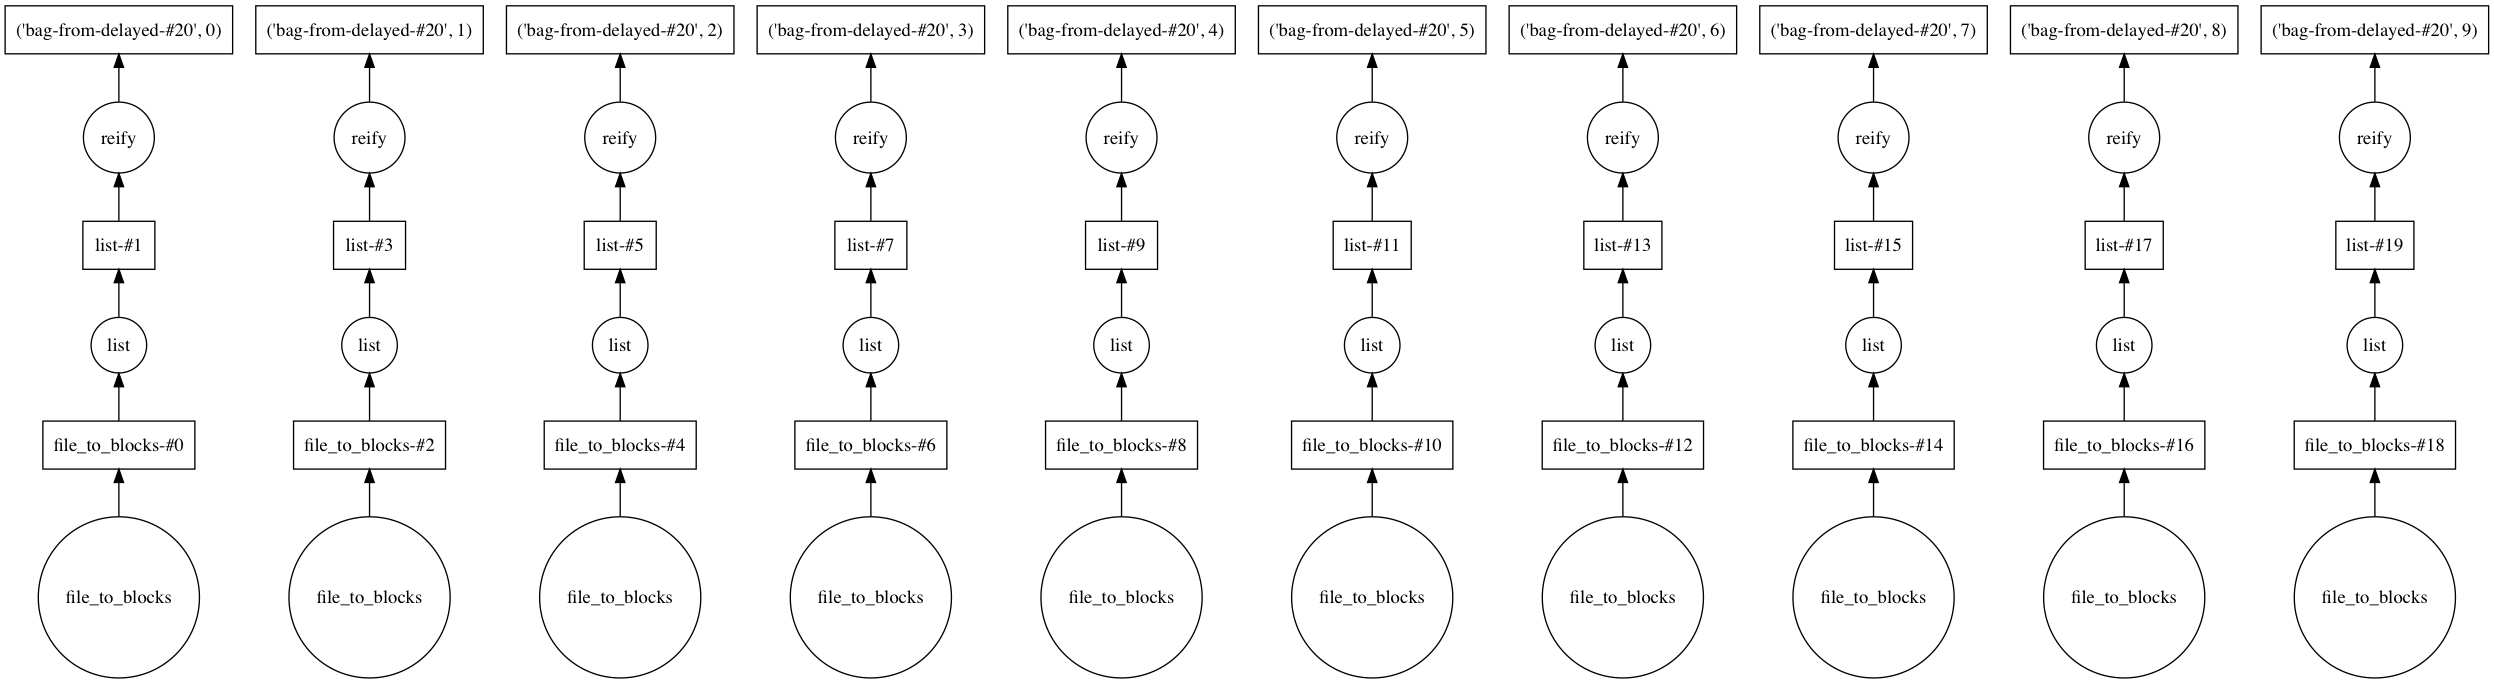

In [34]:
lines.visualize()

In [38]:
lines.take(1) # Look at the first element

('Velit non ipsum ipsum amet non magnam neque. Ipsum ut sed labore ipsum. Consectetur consectetur aliquam aliquam sit numquam. Ut labore numquam dolor. Neque eius magnam consectetur. Quaerat tempora quiquia etincidunt. Dolore magnam consectetur tempora dolorem amet consectetur.\n',)

In [42]:
def words_from_line(line):
    """
    Read a line and return a sorted list of (word, 1) values.
    """
    translator = str.maketrans('', '', string.punctuation)
    output = []
    line = line.strip()
    line = line.translate(translator)
    for word in line.split():
        word = word.lower()
        output.append((word, 1))
    output.sort()
    return output

In [44]:
(lines.map(words_from_line).take(2))

([('aliquam', 1),
  ('aliquam', 1),
  ('amet', 1),
  ('amet', 1),
  ('consectetur', 1),
  ('consectetur', 1),
  ('consectetur', 1),
  ('consectetur', 1),
  ('consectetur', 1),
  ('dolor', 1),
  ('dolore', 1),
  ('dolorem', 1),
  ('eius', 1),
  ('etincidunt', 1),
  ('ipsum', 1),
  ('ipsum', 1),
  ('ipsum', 1),
  ('ipsum', 1),
  ('labore', 1),
  ('labore', 1),
  ('magnam', 1),
  ('magnam', 1),
  ('magnam', 1),
  ('neque', 1),
  ('neque', 1),
  ('non', 1),
  ('non', 1),
  ('numquam', 1),
  ('numquam', 1),
  ('quaerat', 1),
  ('quiquia', 1),
  ('sed', 1),
  ('sit', 1),
  ('tempora', 1),
  ('tempora', 1),
  ('ut', 1),
  ('ut', 1),
  ('velit', 1)],
 [])

In [54]:
mapped_values = (partition_mp(lines.map(words_from_line)))

ValueError: too many values to unpack (expected 2)

In [50]:
(mapped_values.sum().compute())

TypeError: unsupported operand type(s) for +: 'int' and 'list'



# Deploying the MapReduce code on Hadoop

This Python must use the [Hadoop Streaming API](http://hadoop.apache.org/docs/stable/hadoop-streaming/HadoopStreaming.html) to pass data between our Map and Reduce code via Python’s sys.stdin (standard input) and sys.stdout (standard output). 

Download some books
* [The Outline of Science, Vol. 1 (of 4) by J. Arthur Thomson](http://www.gutenberg.org/ebooks/20417.txt.utf-8)
* [Ulysses by James Joyce](http://www.gutenberg.org/files/4300/4300-0.txt)
* [The Art of War by 6th cent. B.C. Sunzi](http://www.gutenberg.org/ebooks/132.txt.utf-8)
* [The Adventures of Sherlock Holmes by Sir Arthur Conan Doyle](http://www.gutenberg.org/ebooks/1661.txt.utf-8)
* [The Devil’s Dictionary by Ambrose Bierce](http://www.gutenberg.org/ebooks/972.txt.utf-8)
* [Encyclopaedia Britannica, 11th Edition, Volume 4, Part 3](http://www.gutenberg.org/ebooks/19699.txt.utf-8)



# Map 

The following Python code read data from sys.stdin, split it into words and output a list of lines mapping words to their (intermediate) counts to sys.stdout. For every word it outputs <word> 1 tuples immediately. 


In [358]:
%%file hadoop/mapper.py
#!/usr/bin/env python
from __future__ import print_function
import sys, string

# input comes from standard input
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()
    # strip punctuation
    line = line.translate(None,string.punctuation)    

    # split the line into words
    words = line.split()
    # increase counters
    for word in words:
        # write the results to standard output;
        # what we output here will be the input for the
        # Reduce step, i.e. the input for reducer.py
        #
        # tab-delimited; the trivial word count is 1
        print ('%s\t%s' % (word, 1))

Overwriting hadoop/mapper.py


In [359]:
!chmod +x hadoop/mapper.py 

# Reduce 

The following code reads the results of mapper.py and sum the occurrences of each word to a final count, and then output its results to sys.stdout.
Remember that Hadoop sorts map output so it is easier to count words.


In [360]:
%%file hadoop/reducer.py
#!/usr/bin/env python
from __future__ import print_function
from operator import itemgetter
import sys


current_word = None
current_count = 0
word = None

# input lines
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()
    
    # parse the input we got from mapper.py
    word, count = line.split('\t', 1)

    # convert count (currently a string) to int
    try:
        count = int(count)
    except ValueError:
        # count was not a number, so silently
        # ignore/discard this line
        continue

    # this IF-switch only works because Hadoop sorts map output
    # by key (here: word) before it is passed to the reducer
    if current_word == word:
        current_count += count
    else:
        if current_word:
            # write result to sys.stdout
            print ('{}\t{}'.format(current_word, current_count))
        current_count = count
        current_word = word

# do not forget to output the last word if needed!
if current_word == word:
    print ('{}\t{}'.format(current_word, current_count))

Overwriting hadoop/reducer.py


In [361]:
!chmod +x hadoop/reducer.py

# Test

In [362]:
!cat hadoop/sample.txt | ./hadoop/mapper.py | sort | ./hadoop/reducer.py

Amet	1
Consectetur	1
Dolor	1
Dolore	1
Dolorem	2
Eius	1
Etincidunt	1
Ipsum	2
Labore	1
Magnam	1
Modi	1
Non	1
Numquam	1
Quaerat	3
Quiquia	1
Quisquam	1
Sed	2
Sit	2
Tempora	1
Voluptatem	1
adipisci	9
aliquam	3
amet	3
consectetur	1
dolor	8
dolore	10
dolorem	7
eius	6
est	4
etincidunt	5
ipsum	2
labore	3
magnam	5
modi	3
neque	4
non	4
numquam	4
porro	4
quaerat	1
quiquia	4
quisquam	3
sed	6
sit	5
tempora	4
ut	6
velit	5
voluptatem	10


## Execution on Hadoop cluster

* Copy books to HDFS
* Run the WordCount MapReduce

Makefile

In [192]:
%%file hadoop/Makefile
HADOOP_TOOLS=/usr/local/Cellar/hadoop/2.8.0/libexec/share/hadoop/tools/lib/
HDFS_DIR=/user/${USER}

BOOKS = books/20417.txt books/5000-8.txt books/4300-0.txt books/132.txt ht books/1661.txt h books/972.txt ht books/19699.txt 

download:
	mkdir -p books
	wget -q -O books/20417.txt http://www.gutenberg.org/ebooks/20417.txt.utf-8
	wget -q -O books/4300-0.txt http://www.gutenberg.org/files/4300/4300-0.txt
	wget -q -O books/132.txt http://www.gutenberg.org/ebooks/132.txt.utf-8
	wget -q -O books/1661.txt http://www.gutenberg.org/ebooks/1661.txt.utf-8
	wget -q -O books/972.txt http://www.gutenberg.org/ebooks/972.txt.utf-8
	wget -q -O books/19699.txt http://www.gutenberg.org/ebooks/19699.txt.utf-8

copy_to_hdfs: ${BOOKS}
	hdfs dfs -put books books
	
run_with_hadoop: 
	hadoop jar ${HADOOP_TOOLS}/hadoop-streaming-2.8.0.jar \
    -file  ${PWD}/mapper.py  -mapper  ${PWD}/mapper.py \
    -file  ${PWD}/reducer.py -reducer ${PWD}/reducer.py \
    -input ${HDFS_DIR}/books/* -output ${HDFS_DIR}/output-hadoop

run_with_yarn: 
	yarn jar ${HADOOP_TOOLS}/hadoop-streaming-2.8.0.jar \
	-file  ${PWD}/mapper.py  -mapper  ${PWD}/mapper.py \
	-file  ${PWD}/reducer.py -reducer ${PWD}/reducer.py \
	-input ${HDFS_DIR}/books/* -output ${HDFS_DIR}/output-yarn


Overwriting hadoop/Makefile


### Run

```bash
$ make run_with_hadoop

$ make run_with_yarn
```
